# Modeling and Simulation in Python

Comparison of the penny models from Chapters 1, 20, and 21

Copyright 2018 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### With air resistance

Next we'll add air resistance using the [drag equation](https://en.wikipedia.org/wiki/Drag_equation)

I'll start by getting the units we'll need from Pint.

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram

<Unit('kilogram')>

Now I'll create a `Params` object to contain the quantities we need.  Using a Params object is convenient for grouping the system parameters in a way that's easy to read (and double-check).

In [3]:
params = Params(height = 381 * m,
                v_init = 0 * m / s,
                g = 9.8 * m/s**2,
                mass = 2.5e-3 * kg,
                diameter = 19e-3 * m,
                rho = 1.2 * kg/m**3,
                v_term = 18 * m / s)

,values
height,381 meter
v_init,0.0 meter / second
g,9.8 meter / second ** 2
mass,0.0025 kilogram
diameter,0.019 meter
rho,1.2 kilogram / meter ** 3
v_term,18.0 meter / second


Now we can pass the `Params` object `make_system` which computes some additional parameters and defines `init`.

`make_system` uses the given radius to compute `area` and the given `v_term` to compute the drag coefficient `C_d`.

In [4]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    unpack(params)
    
    area = np.pi * (diameter/2)**2
    C_d = 2 * mass * g / (rho * area * v_term**2)
    init = State(y=height, v=v_init)
    t_end = 30 * s
    
    return System(params, area=area, C_d=C_d, 
                  init=init, t_end=t_end)

Let's make a `System`

In [5]:
system = make_system(params)

,values
height,381 meter
v_init,0.0 meter / second
g,9.8 meter / second ** 2
mass,0.0025 kilogram
diameter,0.019 meter
rho,1.2 kilogram / meter ** 3
v_term,18.0 meter / second
area,0.0002835287369864788 meter ** 2
C_d,0.4445009981135434 dimensionless
init,y 381 meter v 0.0 meter / secon...


Here's the slope function, including acceleration due to gravity and drag.

In [6]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object
    
    returns: derivatives of y and v
    """
    y, v = state
    unpack(system)
    
    f_drag = rho * v**2 * C_d * area / 2
    a_drag = f_drag / mass
    
    dydt = v
    dvdt = -g + a_drag
    
    return dydt, dvdt

As always, let's test the slope function with the initial conditions.

In [7]:
slope_func(system.init, 0, system)

(0.0 <Unit('meter / second')>, -9.8 <Unit('meter / second ** 2')>)

We can use the same event function as in the previous chapter.

In [8]:
def event_func(state, t, system):
    """Return the height of the penny above the sidewalk.
    """
    y, v = state
    return y

And then run the simulation.

In [10]:
results, details = run_ode_solver(system, slope_func, events=event_func, max_step=0.5)
details.message

'A termination event occurred.'

Here are the results.

In [11]:
results

,y,v
0.000000,381,0
0.000102,381,-0.000999997
0.001122,381,-0.011
0.011327,380.999,-0.110998
0.113367,380.937,-1.10959
0.613367,379.19,-5.79709
1.113367,375.265,-9.74561
1.613367,369.612,-12.701
2.113367,362.72,-14.7232
2.613367,355.009,-16.0234


The final height is close to 0, as expected.

Interestingly, the final velocity is not exactly terminal velocity, which suggests that there are some numerical errors.

We can get the flight time from `results`.

In [12]:
t_sidewalk = get_last_label(results)

22.4397909658943

Here's the plot of position as a function of time.

Saving figure to file figs/chap09-fig02.pdf


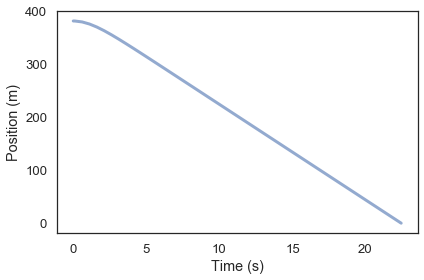

In [13]:
def plot_position(results):
    plot(results.y)
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')
    
plot_position(results)
savefig('figs/chap09-fig02.pdf')

And velocity as a function of time:

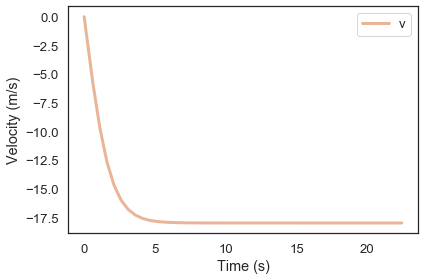

In [14]:
def plot_velocity(results):
    plot(results.v, color='C1', label='v')
        
    decorate(xlabel='Time (s)',
             ylabel='Velocity (m/s)')
    
plot_velocity(results)

From an initial velocity of 0, the penny accelerates downward until it reaches terminal velocity; after that, velocity is constant.

### Back to Chapter 1

We have now considered three models of a falling penny:

1.  In Chapter 1, we started with the simplest model, which includes gravity and ignores drag.

2.  As an exercise in Chapter 1, we did a "back of the envelope" calculation assuming constant acceleration until the penny reaches terminal velocity, and then constant velocity until it reaches the sidewalk.

3.  In this chapter, we model the interaction of gravity and drag during the acceleration phase.

We can compare the models by plotting velocity as a function of time.



In [15]:
g = 9.8
v_term = 18
t_end = 22.4

22.4

In [16]:
ts = linspace(0, t_end, 201)
model1 = -g * ts;

In [17]:
model2 = TimeSeries()
for t in ts:
    v = -g * t
    if v < -v_term:
        model2[t] = -v_term
    else:
        model2[t] = v

In [19]:
results, details = run_ode_solver(system, slope_func, events=event_func, max_step=0.5)
model3 = results.v;

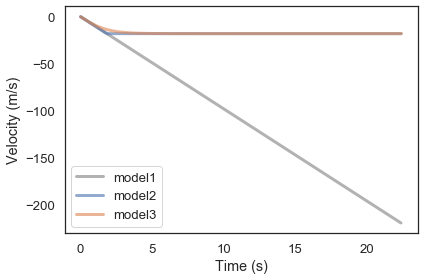

In [20]:
plot(ts, model1, label='model1', color='gray')
plot(model2, label='model2', color='C0')
plot(model3, label='model3', color='C1')
        
decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)')

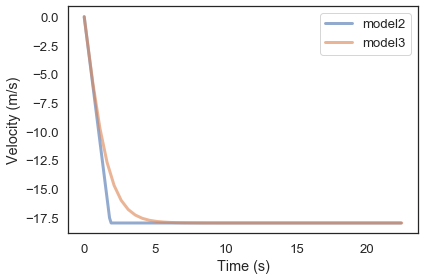

In [21]:
plot(model2, label='model2', color='C0')
plot(results.v, label='model3', color='C1')
        
decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)')

Clearly Model 1 is very different from the other two, which are almost identical except during the transition from constant acceleration to constant velocity.

We can also compare the predictions:

* According to Model 1, the penny takes 8.8 seconds to reach the sidewalk, and lands at 86 meters per second.

* According to Model 2, the penny takes 22.1 seconds and lands at terminal velocity, 18 m/s.

* According to Model 3, the penny takes 22.4 seconds and lands at terminal velocity.

So what can we conclude?  The results from Model 1 are clearly unrealistic; it is probably not a useful model of this system.  The results from Model 2 are off by about 1%, which is probably good enough for most purposes.

In fact, our estimate of the terminal velocity could by off by 10% or more, and the figure we are using for the height of the Empire State Building is not precise either.

So the difference between Models 2 and 3 is swamped by other uncertainties.